In [18]:
# !pip install pytorch-ignite

2860.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 2.6 MB/s eta 0:00:00:00:01


In [2]:
# !pip install torch
# !pip install albumentations==0.4.6
# !pip install torchvision

In [50]:
import re
import pandas as pd
import numpy as np
from PIL import Image
import ast
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow_addons as tfa
import math
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping


In [62]:
# GPU 메모리 설정
# Set the GPU memory growth option
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to allocate only the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        # Enable memory growth to allocate GPU memory on an as-needed basis
        tf.config.experimental.set_memory_growth(gpus[0], True)
        # Set the = activationdesired memory limit (in MB)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]
        )
    except RuntimeError as e:
        print(e)

ValueError: Cannot set memory growth on device when virtual devices configured

In [63]:
# GPU 사용이 가능할 경우, GPU를 사용할 수 있게 함.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [64]:
home_office_desks_df = pd.read_pickle("home_office_desks_df.pkl")

In [65]:
home_office_desks_df.head()

,Category,Title,Price,Product_Info,Product_Feature,Product_Text,Img_URL,Product URL,img_path
1,"[Home & Kitchen, Furniture, Home Office Furnit...",A AIRLLEN Computer Desk 63 Inch Modern Simple ...,$169.99,"{'Brand': 'A AIRLLEN', 'Product Dimensions': '...","{'Shape': 'Rectangular', 'Desk design': 'Compu...",【Actual Table Dimension】63 L x 23.62 D x 28.35...,https://m.media-amazon.com/images/I/71I9DrrwH9...,https://www.amazon.com/AIRLLEN-Computer-Workst...,/home/all/imgs/Desks/AAIRLLENComputerDeskInchM...
2,"[Home & Kitchen, Furniture, Home Office Furnit...",Cubiker Computer Home Office Desk with Drawers...,$79.99,"{'Brand': 'Cubiker', 'Product Dimensions': '23...","{'Shape': 'Rectangular', 'Desk design': 'Compu...",Modern Confident Style: Cubiker office compute...,https://m.media-amazon.com/images/I/81tfZZqqGd...,https://www.amazon.com/Cubiker-Computer-Office...,/home/all/imgs/Desks/CubikerComputerHomeOffice...
3,"[Home & Kitchen, Furniture, Home Office Furnit...",Rise UP Dual Motor Electric Standing Desk 60x3...,$489.99,"{'Brand': 'Uncaged Ergonomics', 'Product Dimen...","{'Shape': 'Rectangular', 'Desk design': 'Compu...","A beautiful, durable, dual-motor electric adju...",https://m.media-amazon.com/images/I/71Weo55ETw...,https://www.amazon.com/Electric-Adjustable-Erg...,/home/all/imgs/Desks/RiseUPDualMotorElectricSt...
4,"[Home & Kitchen, Furniture, Home Office Furnit...","CubiCubi Computer Desk, 40 inch Home Office De...",$54.99,"{'Brand': 'CubiCubi', 'Product Dimensions': '1...","{'Shape': 'Rectangular', 'Desk design': 'Compu...",Modern Simple Style: This computer desk suits ...,https://m.media-amazon.com/images/I/71TfWerRrA...,https://www.amazon.com/Cubicubi-Computer-Offic...,/home/all/imgs/Desks/CubiCubiComputerDeskinchH...
8,"[Home & Kitchen, Furniture, Home Office Furnit...",Furologee Computer Desk with Drawer and Power ...,$109.99,"{'Brand': 'Furologee', 'Product Dimensions': '...","{'Shape': 'Rectangular', 'Desk design': 'Compu...",[Desk with Charging Station]: The computer des...,https://m.media-amazon.com/images/I/71hSkzjDjd...,https://www.amazon.com/Furologee-Computer-Outl...,/home/all/imgs/Desks/FurologeeComputerDeskwith...


In [66]:
home_office_desks_df.columns

Index(['Category', 'Title', 'Price', 'Product_Info', 'Product_Feature',
       'Product_Text', 'Img_URL', 'Product URL', 'img_path'],
      dtype='object')

In [67]:
home_office_desks_df.iloc[0,3]

'{\'Brand\': \'A AIRLLEN\', \'Product Dimensions\': \'47"D x 23"W x 28.35"H\', \'Color\': \'Brown\', \'Style\': \'Modern\', \'Base Material\': \'Metal\', \'Top Material Type\': \'Engineered Wood\', \'Finish Type\': \'Laminated\', \'Special Feature\': \'Adjustable\', \'Room Type\': \'Office\', \'Recommended Uses For Product\': \'Working, Writing, Gaming\'}'

In [68]:
home_office_desks_df.shape

(2559, 9)

In [69]:
# 1. 데이터 준비
import os
import json  
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# 스타일 확인
styles = ['Classic', 'Contemporary', 'Country', 'Minimalism', 'Modern', 'Unique', 'Urban']

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class HomeOfficeDeskDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (DataFrame): 'home_office_desks_df' 데이터프레임.
            root_dir (string): 이미지 파일이 저장된 폴더의 경로.
            transform (callable, optional): 적용할 변환 (예: 데이터 증강).
        """
        self.desk_df = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.desk_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.desk_df.iloc[idx, 8])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # 문자열을 딕셔너리로 변환
        product_info_str = self.desk_df.iloc[idx, 3]
        product_info = eval(product_info_str)
        style = product_info['Style'].capitalize()

        label = styles.index(style)  # 'styles' 리스트에서 해당 스타일의 인덱스를 라벨로 사용

        return image, label


dataset = HomeOfficeDeskDataset(
    dataframe=home_office_desks_df,
    root_dir='/home/all/imgs/Desks',
    transform=transform
)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [70]:
num_samples_to_check = 5
for i, (images, labels) in enumerate(data_loader):
    if i >= num_samples_to_check:
        break

ValueError: 'Modern, contemporary' is not in list

In [25]:
print(dataset)

In [26]:
# 특정 인덱스(예: 0번 인덱스)의 값을 출력해 확인
sample_data = home_office_desks_df.iloc[0, 3]
print(sample_data)

{'Brand': 'A AIRLLEN', 'Product Dimensions': '47"D x 23"W x 28.35"H', 'Color': 'Brown', 'Style': 'Modern', 'Base Material': 'Metal', 'Top Material Type': 'Engineered Wood', 'Finish Type': 'Laminated', 'Special Feature': 'Adjustable', 'Room Type': 'Office', 'Recommended Uses For Product': 'Working, Writing, Gaming'}


In [27]:
# 2. 모델 변경
import torch.nn as nn
# 기존 unet
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
	    # 1x1 convolution layer 추가
        self.output1 = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    

    

# 수정할 부분


class ModifiedUNet(UNet):  # 기존 UNet 클래스를 상속
    def __init__(self, num_classes):
        super(ModifiedUNet, self).__init__(num_classes)
        self.output = nn.Conv2d(64, num_classes, kernel_size=1)  # 1x1 컨볼루션으로 클래스 수 조정

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, 64, 256, 256] -> [-1, 64, 256, 256]
        output_out1 = self.output(output_out) # [-1, num_classes, 256, 256]
        output_out1 = self.output(output_out1)
        
        return output_out1

In [28]:
# 3. 훈련
import torch.optim as optim
from torch.utils.data import DataLoader
from ignite.handlers import EarlyStopping

from torchvision import transforms

변환_설정 = transforms.Compose([
    transforms.Resize((256, 256)),  # 이미지 크기를 256x256으로 조정
    transforms.ToTensor(),          # 이미지를 PyTorch 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])



# 데이터셋 및 데이터 로더 설정
dataset = HomeOfficeDeskDataset(home_office_desks_df, '이미지_폴더_경로', transform=변환_설정)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 모델, 손실 함수, 옵티마이저 설정
model = ModifiedUNet(num_classes=len(styles)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose  # 여기에 verbose 인자 추가
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''모델 저장하는 코드 (옵션)'''
        pass

early_stopping = EarlyStopping(patience=5, verbose=True)

epochs = 25  # 모델을 25번의 에폭(epoch) 동안 훈련시킬 설정
for epoch in range(epochs):
    epoch_loss = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    early_stopping(epoch_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

AttributeError: shape

In [13]:
# 4. 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 평가 데이터셋에서 예측
# ...

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

NameError: name 'y_true' is not defined

In [10]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import cv2
import numpy as np
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
# from unet_model import UNet  # U-Net 모델 아키텍처가 정의된 가정된 모듈

In [11]:
home_office_desks_df.iloc[0,-1]

'/home/all/imgs/Desks/AAIRLLENComputerDeskInchModernSimpleSturdyNotebookWritingDeskStudyOfficeTableforHomeOfficeDinningTableWorkstationDeskEscritoriodeOrdenador.jpg'

/home/myeong/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/myeong/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


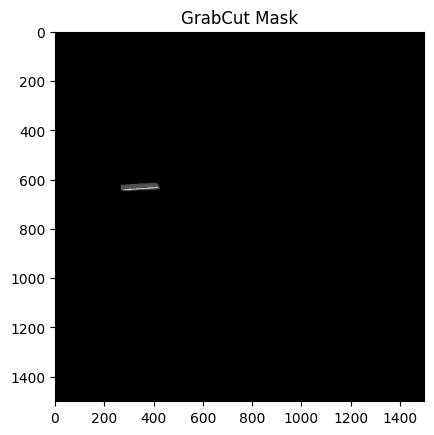

NameError: name 'dec2_1' is not defined

In [12]:
# 이거 수정하나다 끝
model_path = '/home/myeong/unet_model.pth'  
unet_model.load_state_dict(torch.load(model_path))

# 이미지 로드 함수 정의
def load_image(image_path):
    # 이미지 파일이 존재하는지 확인
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    image = cv2.imread(image_path)
    return image

# 실제 이미지 로드
image_path = '/home/all/imgs/Desks/AAIRLLENComputerDeskInchModernSimpleSturdyNotebookWritingDeskStudyOfficeTableforHomeOfficeDinningTableWorkstationDeskEscritoriodeOrdenador.jpg'
image = load_image(image_path)

# 초기 마스크와 배경/전경 모델을 생성
mask = np.zeros(image.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Faster R-CNN 모델 불러오기
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# 이미지를 텐서로 변환
tensor_image = F.to_tensor(image)

# 이미지에서 객체 탐지
with torch.no_grad():
    prediction = model([tensor_image])[0]

# 탐지된 객체 중 하나 선택 (예: 첫 번째 객체)
box = prediction["boxes"][0].cpu().numpy()  # (x_min, y_min, x_max, y_max)
rect = (int(box[0]), int(box[1]), int(box[2] - box[0]), int(box[3] - box[1]))

# GrabCut 실행
cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# 배경인 픽셀은 0, 그 외에는 1로 설정하여 최종 마스크를 생성
mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8')
grabcut_image = image * mask2[:, :, np.newaxis]

# 결과 확인
plt.imshow(cv2.cvtColor(grabcut_image, cv2.COLOR_BGR2RGB))
plt.title("GrabCut Mask")
plt.show()

# U-Net 모델 로드
unet_model = UNet()
unet_model.load_state_dict(torch.load('unet_model.pth'))

# 세그멘테이션 수행
unet_model.eval()
with torch.no_grad():
    prediction = unet_model(tensor_image.unsqueeze(0))

# 결과 시각화
predicted_mask = torch.sigmoid(prediction).squeeze(0)
predicted_mask = predicted_mask.cpu().numpy()
plt.imshow(predicted_mask, cmap='gray')
plt.title("Segmentation Result")
plt.show()

In [36]:
# # 데이터프레임에서 실제 이미지 파일 경로를 가져옵니다.
# image_path = '/home/all/imgs/Desks/AAIRLLENComputerDeskInchModernSimpleSturdyNotebookWritingDeskStudyOfficeTableforHomeOfficeDinningTableWorkstationDeskEscritoriodeOrdenador.jpg'

# # 이미지 로드 함수 정의
# def load_image(image_path):
#     # 이미지 파일이 존재하는지 확인
#     if not os.path.exists(image_path):
#         raise FileNotFoundError(f"Image file not found: {image_path}")
    
#     image = Image.open(image_path).convert("RGB")
#     transform = transforms.Compose([transforms.ToTensor()])
#     image = transform(image)
#     return image

# # 실제 이미지 로드
# image = load_image(image_path)



# # 초기 마스크와 배경/전경 모델을 생성
# mask = np.zeros(image.shape[:2], np.uint8)
# bgdModel = np.zeros((1, 65), np.float64)
# fgdModel = np.zeros((1, 65), np.float64)

# # rect
# # 이미지를 불러오고, 모델에 맞게 전처리하는 함수
# def load_image(image_path):
#     image = Image.open(image_path).convert("RGB")
#     transform = transforms.Compose([transforms.ToTensor()])
#     image = transform(image)
#     return image

# # 이미지 로드
# image_path = "path_to_your_image.jpg"
# image = load_image(image_path)

# # YOLO 모델 불러오기 (여기서는 Faster R-CNN을 사용한 예시입니다)
# model = fasterrcnn_resnet50_fpn(pretrained=True)
# model.eval()

# # 이미지에서 객체 탐지
# with torch.no_grad():
#     prediction = model([image])

# # 탐지된 객체 중 하나 선택 (예: 첫 번째 객체)
# boxes = prediction[0]["boxes"]
# labels = prediction[0]["labels"]
# scores = prediction[0]["scores"]

# # 가장 확률이 높은 객체의 경계 상자 선택
# # 이 부분은 필요에 따라 수정할 수 있습니다.
# box = boxes[0].cpu().numpy()  # (x_min, y_min, x_max, y_max)
# rect = (int(box[0]), int(box[1]), int(box[2] - box[0]), int(box[3] - box[1]))




# # GrabCut 실행
# cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# # 배경인 픽셀은 0, 그 외에는 1로 설정하여 최종 마스크를 생성
# mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8')
# image = image * mask2[:, :, np.newaxis]

# # 결과 확인
# cv2.imshow("GrabCut Mask", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# # U-Net 모델 로드 (미리 훈련된 가정하에)
# unet_model = UNet()
# unet_model.load_state_dict(torch.load('unet_model.pth'))

# # 이미지를 U-Net 모델에 적합한 형태로 변환
# tensor_image = transforms.ToTensor()(image).unsqueeze(0)

# # 세그멘테이션 수행
# unet_model.eval()  # 모델을 평가 모드로 설정
# with torch.no_grad():
#     prediction = unet_model(tensor_image)

# # 결과 시각화
# predicted_mask = torch.sigmoid(prediction).squeeze(0)
# predicted_mask = predicted_mask.cpu().numpy()
# plt.imshow(predicted_mask, cmap='gray')
# plt.show()

FileNotFoundError: Image file not found: \home\all\imgs\Desks\AAIRLLENComputerDeskInchModernSimpleSturdyNotebookWritingDeskStudyOfficeTableforHomeOfficeDinningTableWorkstationDeskEscritoriodeOrdenador.jpg